In [1]:
import sys
import os

# Get the absolute path to the root directory where UQ_toolbox.py is located
root_dir = os.path.abspath(os.path.join(os.path.dirname('medMNIST'), '..'))
sys.path.append(root_dir)

In [2]:
import medmnist
from medmnist import INFO
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from torchvision.models import resnet18
import random
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from scipy.ndimage import zoom
import UQ_toolbox as uq
import torchvision.transforms.functional as TF
from matplotlib.patches import PathPatch, FancyBboxPatch
from matplotlib.path import Path
import torch.nn.functional as F
import matplotlib.patheffects as path_effects

In [3]:
# Define ResNet18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = resnet18(weights='DEFAULT')
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [4]:
# Load organAMNIST dataset
data_flag = 'organamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
num_classes = len(info['label'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

test_dataset = DataClass(split='test', download=download, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [5]:
# Set the seed for reproducibility
random.seed(123)

# Get 5 random indices
random_indices = random.sample(range(len(test_dataset)), 15)

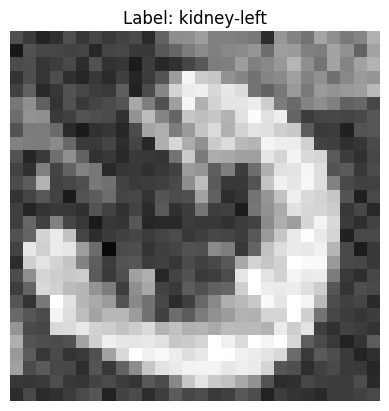

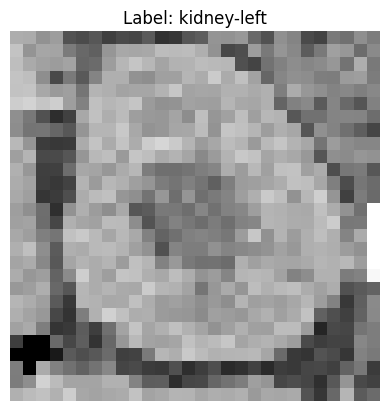

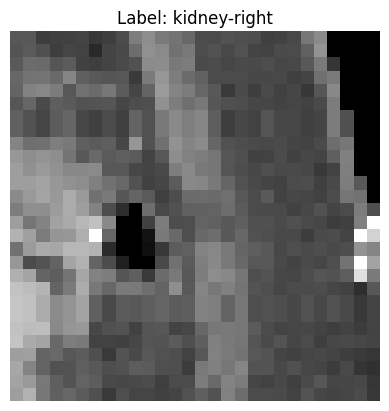

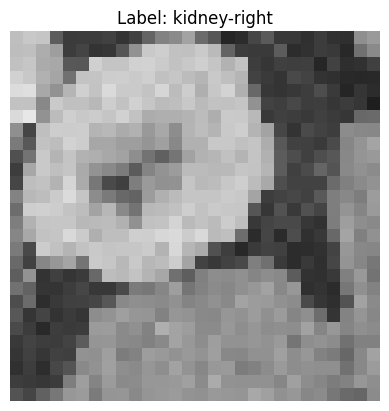

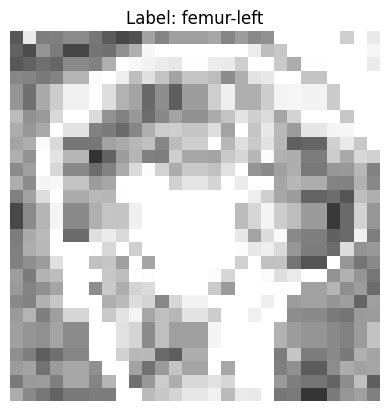

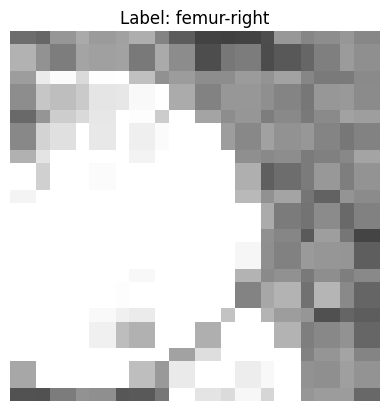

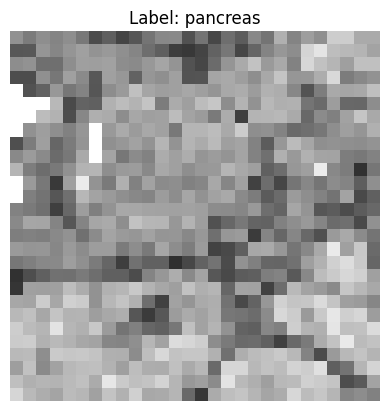

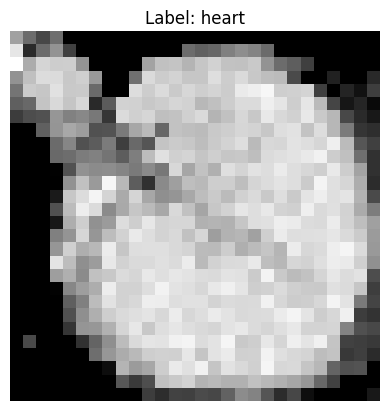

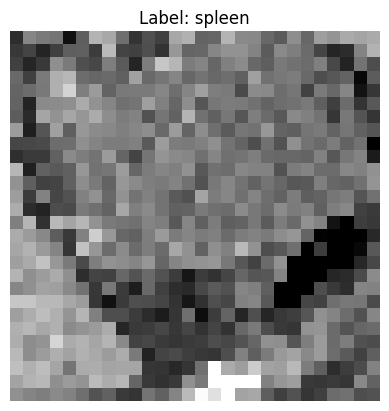

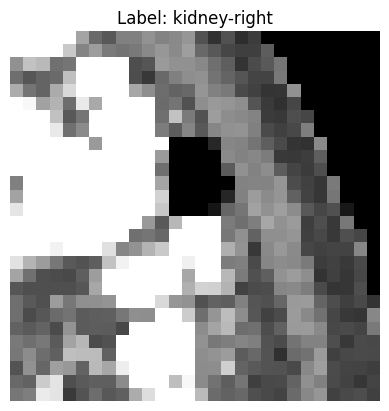

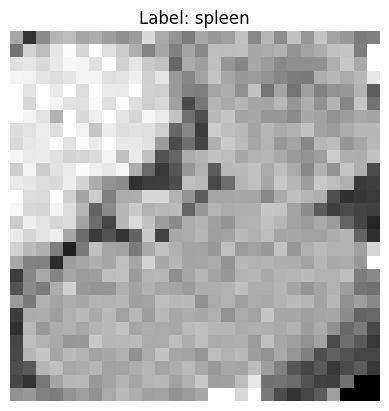

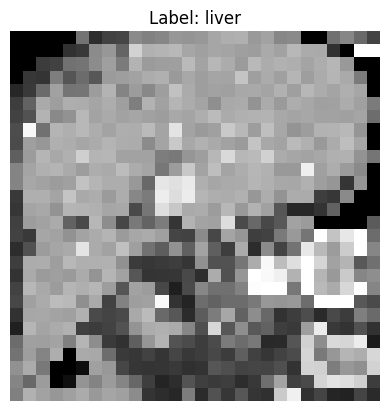

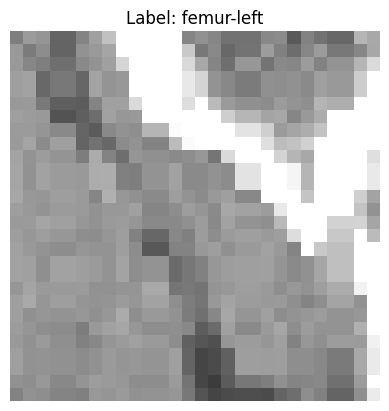

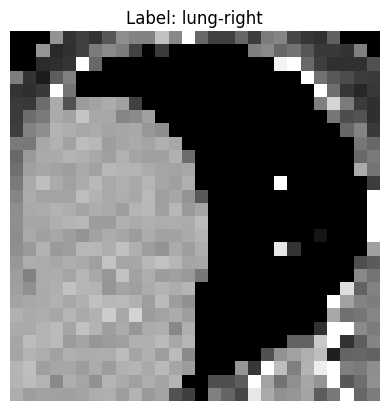

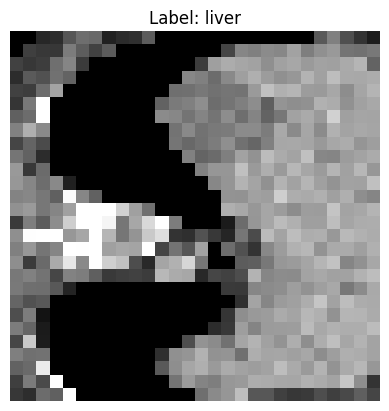

In [47]:
# Create a directory to save the images
os.makedirs("random_images", exist_ok=True)


# Display and save the images
for i, idx in enumerate(random_indices):
    image, label = test_dataset[idx]
    plt.imshow(image.permute(1, 2, 0).squeeze(), cmap="gray")
    plt.title(f"Label: {info['label'][str(label.item())]}")
    plt.axis("off")
    plt.show()
    
    # Save the image
    save_image(image, f"random_images/image_{i}_label_{label}.png")

In [6]:
# Load saved models
models = []
for i in range(5):
    model = ResNet18(num_classes=num_classes)
    model.load_state_dict(torch.load(f'resnet18_organamnist{i}.pt'))
    model = model.to(device)
    model.eval()
    models.append(model)

In [7]:
# Compute uncertainty for all test samples
uncertainty_scores = []
# Perform inference on the test set
y_true = []
y_scores = []
indiv_scores = [[], [], [], [], []]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = [model(data) for model in models]
        for ind, output in zip(indiv_scores, outputs):
            ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
            
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        y_true.extend(target.cpu().numpy().flatten())
        y_scores.extend(avg_output.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)
y_prob = np.array(F.softmax(torch.tensor(y_scores), dim=1))
uncertainty = uq.distance_to_hard_labels_computation(y_prob)


/tmp/ipykernel_618417/3934560096.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
/tmp/ipykernel_618417/3934560096.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_prob = np.array(F.softmax(torch.tensor(y_scores), dim=1))


In [8]:
# Sort uncertainty scores and get the indices
sorted_indices = np.argsort(uncertainty)

# Select 10 low UQ cases and 10 high UQ cases
selected_indices = list(sorted_indices[:10]) + list(sorted_indices[-10:])

# Shuffle the selected indices
random.shuffle(selected_indices)

# Create a directory to save the images
os.makedirs("selected_uq_images", exist_ok=True)

# Save the selected images
for i, idx in enumerate(selected_indices):
    image, label = test_dataset[idx]
    save_image(image, f"selected_uq_images/image_{i}_label_{label}.png")

In [9]:
# Define a function to register hooks and capture outputs
def register_hooks(model, layers):
    outputs = {}

    def hook_fn(module, input, output):
        outputs[module] = output

    hooks = []
    for layer in layers:
        hooks.append(layer.register_forward_hook(hook_fn))
    return outputs, hooks

# Define the layers to capture
layers_to_capture = [
    model.model.layer1,
    model.model.layer2,
    model.model.layer3,
    model.model.layer4
]

# Register hooks
layer_outputs, hooks = register_hooks(model, layers_to_capture)


In [91]:
# MSR

info = {
    '0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left',
    '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'
}

combined_outputs = []
layer_filter_positions_per_frame = []
image_centers_per_frame = []
softmax_digit_positions_per_frame = []
label_text_positions_per_frame = []
num_frames = None

for i in range(20):
    combined_lay = []
    sample_image, _ = test_dataset[selected_indices[i]]
    sample_image = sample_image.unsqueeze(0).to(device)

    target_size = (14, 14)
    for lay in range(4):
        combined_frames = []
        layer_outputs, hooks = register_hooks(model, layers_to_capture)
        _ = model(sample_image)

        for output in layer_outputs[list(layer_outputs)[lay]]:
            output = output.squeeze(0).cpu().detach().numpy()
            if num_frames is None:
                num_frames = 10

            resized_output = np.array([
                zoom(frame, (target_size[0] / frame.shape[0], target_size[1] / frame.shape[1]))
                for frame in output
            ])
            combined_frames.append(resized_output)

        frames = np.vstack([
            np.vstack([
                combined_frames[0][frame],
                np.full((combined_frames[0][frame].shape[0], combined_frames[0][frame].shape[0]), -0.46953085064888)
            ])
            for frame in range(num_frames)
        ])
        combined_lay.append(frames)

    final_lay = np.hstack([
        np.hstack([
            combined_lay[layer],
            np.full((combined_lay[layer].shape[0], combined_lay[layer].shape[1]), -0.46953085064888)
        ])
        for layer in range(4)
    ])

    final_height = final_lay.shape[0]
    resized_height = final_height // 4
    orig_pil = TF.to_pil_image(sample_image.squeeze(0).cpu())
    orig_resized = TF.resize(orig_pil, size=(resized_height, resized_height))
    orig_image_np = np.array(orig_resized).astype(np.float32)

    if orig_image_np.ndim == 3:
        orig_image_np = np.mean(orig_image_np, axis=2)

    orig_image_np = (orig_image_np - orig_image_np.min()) / (orig_image_np.max() - orig_image_np.min())
    orig_image_np = orig_image_np * (np.max(final_lay) - (-0.46953085064888)) + (-0.46953085064888)

    extra_top = int(final_height * 0.05)
    top_pad = (final_height - resized_height) // 2 + extra_top
    bottom_pad = final_height - resized_height - top_pad
    pad_width = int(final_lay.shape[1] * 0.65)

    orig_image_padded = np.pad(
        orig_image_np,
        ((top_pad, bottom_pad), (pad_width, pad_width)),
        constant_values=-0.46953085064888
    )

    with torch.no_grad():
        logits = model(sample_image)
        probs = F.softmax(logits, dim=1).squeeze().cpu().numpy()

    final_frame = np.hstack([
        orig_image_padded,
        final_lay,
        np.full((final_lay.shape[0], target_size[1]), -0.46953085064888),
        np.full((final_lay.shape[0], target_size[1]), -0.46953085064888)
    ])

    softmax_digit_positions = []
    label_text_positions = []
    for idx in range(11):
        y = idx * target_size[0] * 2 + target_size[0] // 2
        x = final_frame.shape[1] + 5
        softmax_digit_positions.append((x, y))
        label_text_positions.append((x + 35, y))  # reduced spacing here

    pad_y = int(0.05 * final_frame.shape[0])
    pad_x = int(0.05 * final_frame.shape[1])
    final_frame = np.pad(
        final_frame,
        ((pad_y, pad_y), (pad_x, pad_x)),
        constant_values=-0.46953085064888
    )
    combined_outputs.append(final_frame)
    softmax_digit_positions_per_frame.append([(x + pad_x, y + pad_y) for (x, y) in softmax_digit_positions])
    label_text_positions_per_frame.append([(x + pad_x, y + pad_y) for (x, y) in label_text_positions])

    layer_positions = []
    x_offset = orig_image_padded.shape[1]
    for layer in combined_lay:
        x_center = x_offset + target_size[1] // 2
        y_centers = [f * target_size[0] * 2 + target_size[0] // 2 for f in range(num_frames)]
        layer_positions.append([(x_center + pad_x, y + pad_y) for y in y_centers])
        x_offset += target_size[1] * 2

    image_center = (orig_image_padded.shape[1] // 2 + pad_x, final_height // 2 + pad_y)
    layer_filter_positions_per_frame.append(layer_positions)
    image_centers_per_frame.append(image_center)

fig, ax = plt.subplots(figsize=(40, 20))
connection_patches = []
first_frame_layers = layer_filter_positions_per_frame[0]
first_softmax_positions = softmax_digit_positions_per_frame[0]
filter_half_width = target_size[1] // 2

for dest in first_frame_layers[0]:
    src_x = int(orig_image_padded.shape[1] / 1.5)
    src_y = image_centers_per_frame[0][1]
    src = (src_x + pad_x, src_y)
    dst = (dest[0] - filter_half_width, dest[1])
    ctrl1 = (src[0] + (dst[0] - src[0]) * 0.3, src[1])
    ctrl2 = (src[0] + (dst[0] - src[0]) * 0.7, dst[1])
    path = Path([src, ctrl1, ctrl2, dst], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    connection_patches.append(PathPatch(path, facecolor='none', edgecolor='black', lw=1.5, alpha=0.2))

for l in range(len(first_frame_layers) - 1):
    src_layer = first_frame_layers[l]
    dst_layer = first_frame_layers[l + 1]
    for src in src_layer:
        for dst in dst_layer:
            src_pos = (src[0] + filter_half_width, src[1])
            dst_pos = (dst[0] - filter_half_width, dst[1])
            ctrl1 = (src_pos[0] + (dst_pos[0] - src_pos[0]) * 0.3, src_pos[1])
            ctrl2 = (src_pos[0] + (dst_pos[0] - src_pos[0]) * 0.7, dst_pos[1])
            path = Path([src_pos, ctrl1, ctrl2, dst_pos], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
            connection_patches.append(PathPatch(path, facecolor='none', edgecolor='black', lw=2.0, alpha=0.1))

last_layer = first_frame_layers[-1]
for src in last_layer:
    for dst in first_softmax_positions:
        src_pos = (src[0] + filter_half_width, src[1])
        dst_pos = dst
        ctrl1 = (src_pos[0] + (dst_pos[0] - src_pos[0]) * 0.3, src_pos[1])
        ctrl2 = (src_pos[0] + (dst_pos[0] - src_pos[0]) * 0.7, dst_pos[1])
        path = Path([src_pos, ctrl1, ctrl2, dst_pos], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
        connection_patches.append(PathPatch(path, facecolor='none', edgecolor='black', lw=2.0, alpha=0.1))

# --- ANIMATION ---
def update(frame_idx):
    ax.clear()
    # Add this after ax.clear() in the update function
    ax.set_xlim(0, combined_outputs[frame_idx].shape[1] + 170)
    ax.set_ylim(combined_outputs[frame_idx].shape[0] +10, 0)  # Invert y-axis for image coordinates
    ax.imshow(combined_outputs[frame_idx], cmap='gray_r', vmin=-0.46953085064888, vmax=np.max(combined_outputs[frame_idx]))
    ax.axis('off')

    for patch in connection_patches:
        ax.add_patch(patch)

    with torch.no_grad():
        softmax_values = F.softmax(model(test_dataset[selected_indices[frame_idx]][0].unsqueeze(0).to(device)), dim=1).squeeze().detach().cpu().numpy()
        distance = uq.distance_to_hard_labels_computation(softmax_values)
        
    # Add softmax probabilities and labels
    for idx, prob in enumerate(softmax_values):
        x, y = softmax_digit_positions_per_frame[frame_idx][idx]
        ax.text(x + 10, y, f"{prob:.3f}", ha='left', va='center', fontsize=28, color='black',
                path_effects=[path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])

        lx, ly = label_text_positions_per_frame[frame_idx][idx]
        ax.text(lx + 5, ly, info[str(idx)], ha='left', va='center', fontsize=35, color='black',
                path_effects=[path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])

    # Highlight the top prediction
    top_idx = int(softmax_values.argmax())
    x, y = softmax_digit_positions_per_frame[frame_idx][top_idx]
    lx, _ = label_text_positions_per_frame[frame_idx][top_idx]
    box_width = lx - x + 65
    rect = FancyBboxPatch((x + 5, y - target_size[0]), box_width, target_size[0] * 2,
                          boxstyle="round,pad=0.3", edgecolor='black', linewidth=3, facecolor='none')
    ax.add_patch(rect)
    
    # Add Max Softmax Response (MSR) bar plot
    msr_ax = fig.add_axes([0.85, 0.3, 0.1, 0.4])  # Adjust position and size of the bar plot
    msr_ax.bar(0, distance, 0.05)#, edgecolor='black')
    msr_ax.set_xlim(-0.06, 0.06)
    msr_ax.set_ylim(0, 1)
    msr_ax.set_xlabel("Max Softmax Response", fontsize=35, labelpad=20)
    msr_ax.tick_params(axis='y', which='major', labelsize=30)
    msr_ax.set(xticklabels=[])
    msr_ax.grid(axis='x', linestyle='--', alpha=0.5)
    
    # Add connection patch between circled label and bar plot
    label_pos = (x + box_width + 5, y)  # Position of the circled label
    bar_pos = (combined_outputs[frame_idx].shape[1] + 150, msr_ax.get_position().y0 * combined_outputs[frame_idx].shape[0] + 65)  # Approximate bar plot position
    ctrl1 = (label_pos[0] + (bar_pos[0] - label_pos[0]) * 0.3, label_pos[1])
    ctrl2 = (label_pos[0] + (bar_pos[0] - label_pos[0]) * 0.7, bar_pos[1])
    path = Path([label_pos, ctrl1, ctrl2, bar_pos], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    connection_patch = PathPatch(path, facecolor='none', edgecolor='black', lw=2, alpha=0.8)
    ax.add_patch(connection_patch)

ani = FuncAnimation(fig, update, frames=20, interval=1000)
ani.save('layer_output_resized_comb_layers_MSR.mp4', writer="ffmpeg", fps=1, dpi=150)
plt.close(fig)


In [19]:
# --- ENSEMBLING ILLUSTRATION ---
fig, ax = plt.subplots(figsize=(20, 10))

# --- ANIMATION ---
def update_ensembling(frame_idx):
    ax.clear()
    ax.set_xlim(-10, 16)  # Adjust x-axis to fit the image and digits
    ax.set_ylim(-1, 6)  # 5 models (lines) + 1 row for standard deviation
    ax.axis('off')

    # Display the original image on the left
    sample_image, _ = test_dataset[selected_indices[frame_idx]]
    ax.imshow(sample_image.permute(1, 2, 0).squeeze(), cmap="gray", extent=[-10, -5, 0, 5])

    # Get the softmax probabilities for the current frame
    with torch.no_grad():
        softmax_values_per_model = [
            F.softmax(model(sample_image.unsqueeze(0).to(device)), dim=1).squeeze().cpu().numpy()
            for model in models
        ]

    # Compute standard deviation for each class across models
    softmax_values_array = np.array(softmax_values_per_model)  # Shape: (num_models, num_classes)
    std_devs = np.std(softmax_values_array, axis=0)

    # Display the softmax probabilities as digits
    for model_idx, softmax_values in enumerate(softmax_values_per_model):
        y_position = 5 - model_idx  # Line position for each model
        for class_idx, prob in enumerate(softmax_values):
            x_position = class_idx + 1  # Offset for class positions
            ax.text(x_position, y_position, f"{prob:.2f}", ha='center', va='center', fontsize=12)

    # Add a new row for standard deviation values
    y_position = 0  # Position for the standard deviation row
    for class_idx, std_dev in enumerate(std_devs):
        x_position = class_idx + 1  # Offset for class positions
        ax.text(x_position, y_position, f"{std_dev:.2f}", ha='center', va='center', fontsize=12, color='red')

    # Add connections from the original image to the softmax digits
    for model_idx in range(len(softmax_values_per_model)):
        src_x = -5  # End of the original image
        src_y = 2.5  # Vertical center of the original image
        dst_x = -2  # Stop even earlier before the digits line
        dst_y = 5 - model_idx  # Line position for each model

        # Create a curved connector
        ctrl1 = (src_x + (dst_x - src_x) * 0.3, src_y)
        ctrl2 = (src_x + (dst_x - src_x) * 0.7, dst_y)
        path = Path([ (src_x, src_y), ctrl1, ctrl2, (dst_x, dst_y) ], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
        connector = PathPatch(path, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
        ax.add_patch(connector)

    # Add a connector from the end of column 11 (line 6) to the bar plot
    std_src_x = 11.5  # End of column 11
    std_src_y = 0  # Line 6
    bar_dst_x = 13  # Middle of the bar plot
    bar_dst_y = 2.5  # Vertical center of the bar plot

    # Create a curved connector for the 11th column
    ctrl1 = (std_src_x + (bar_dst_x - std_src_x) * 0.3, std_src_y)
    ctrl2 = (std_src_x + (bar_dst_x - std_src_x) * 0.7, bar_dst_y)
    path = Path([ (std_src_x, std_src_y), ctrl1, ctrl2, (bar_dst_x, bar_dst_y) ], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    std_connector = PathPatch(path, facecolor='none', edgecolor='red', lw=2, alpha=0.8)
    ax.add_patch(std_connector)

    # Add a bar plot for the mean of standard deviations
    mean_std_dev = np.mean(std_devs)
    bar_ax = fig.add_axes([0.85, 0.3, 0.1, 0.4])  # Position and size of the bar plot
    bar_ax.bar(0, mean_std_dev, 0.05)
    bar_ax.set_xlim(-0.06, 0.06)
    bar_ax.set_ylim(0, 0.2)
    bar_ax.set_xticks([])
    bar_ax.set_xlabel("Mean std dev ensembling", fontsize=14, labelpad=10)
    bar_ax.tick_params(axis='y', labelsize=12)
    bar_ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Add class names as a single line above the table
    class_names = [info['label'][str(i)] for i in range(11)]  # Extract class names from the `info['label']` dictionary
    for class_idx, class_name in enumerate(class_names):
        x_position = class_idx + 1  # Offset for class positions
        ax.text(x_position, 6, class_name, ha='center', va='center', fontsize=12, color='black')  # Position above the table

ani = FuncAnimation(fig, update_ensembling, frames=20, interval=1000)
ani.save('ensembling_softmax_results.mp4', writer="ffmpeg", fps=1, dpi=150)
plt.close(fig)

In [ ]:
from torchvision.transforms import RandAugment

# --- TTA ILLUSTRATION ---
fig, ax = plt.subplots(figsize=(20, 10))

# Define RandAugment transformation
rand_augment = RandAugment(num_ops=2, magnitude=20)

# --- ANIMATION ---
def update_tta(frame_idx):
    ax.clear()
    ax.set_xlim(-10, 16)  # Adjust x-axis to fit the image and digits
    ax.set_ylim(-1, 6)  # 5 augmentations (lines) + 1 row for standard deviation
    ax.axis('off')

    # Display the original image on the left
    sample_image, _ = test_dataset[selected_indices[frame_idx]]
    ax.imshow(sample_image.permute(1, 2, 0).squeeze(), cmap="gray", extent=[-10, -5, 0, 5])

    # Convert the sample image to uint8 before applying RandAugment
    sample_image_uint8 = (sample_image * 255).byte()
    
    # Generate 5 augmentations of the original image
    augmented_images = [rand_augment(sample_image_uint8).float().div(255) for _ in range(5)]

    # Define padding between the original image and augmentations
    horizontal_padding = -2  # Padding between the original image and augmentations
    vertical_padding = 0.1#0.5  # Padding between augmentations

    # Display the augmentations as a column with padding
    for i, aug_image in enumerate(augmented_images):
        ax.imshow(
            aug_image.permute(1, 2, 0).squeeze(),
            cmap="gray",
            extent=[
                -5 - horizontal_padding,  # Add horizontal padding
                -4 - horizontal_padding,
                5 - i - i * vertical_padding,  # Add vertical padding
                4 - i - i * vertical_padding
            ]
        )

    # Get the softmax probabilities for the current frame using model 0
    with torch.no_grad():
        softmax_values_per_augmentation = [
            F.softmax(models[0](aug_image.unsqueeze(0).to(device)), dim=1).squeeze().cpu().numpy()
            for aug_image in augmented_images
        ]

    # Compute standard deviation for each class across augmentations
    softmax_values_array = np.array(softmax_values_per_augmentation)  # Shape: (num_augmentations, num_classes)
    std_devs = np.std(softmax_values_array, axis=0)

    # Display the softmax probabilities as digits
    for aug_idx, softmax_values in enumerate(softmax_values_per_augmentation):
        y_position = 5 - aug_idx - aug_idx * vertical_padding  # Match y positions with padding
        for class_idx, prob in enumerate(softmax_values):
            x_position = class_idx + 1  # Offset for class positions
            ax.text(x_position, y_position, f"{prob:.2f}", ha='center', va='center', fontsize=12)

    # Add a new row for standard deviation values
    y_position = -1  # Position for the standard deviation row
    for class_idx, std_dev in enumerate(std_devs):
        x_position = class_idx + 1  # Offset for class positions
        ax.text(x_position, y_position, f"{std_dev:.2f}", ha='center', va='center', fontsize=12, color='red')

    # Update connectors to account for the padding
    for aug_idx in range(len(augmented_images)):
        src_x = -5  # Start at the end of the original image
        src_y = 2.5  # Vertical center of the original image
        dst_x = -4.5 - horizontal_padding  # Stop at the beginning of the augmented image
        dst_y = 4.5 - aug_idx - aug_idx * vertical_padding  # Adjust destination y-coordinate for vertical padding

        # Create a curved connector
        ctrl1 = (src_x + (dst_x - src_x) * 0.3, src_y)
        ctrl2 = (src_x + (dst_x - src_x) * 0.7, dst_y)
        path = Path([(src_x, src_y), ctrl1, ctrl2, (dst_x, dst_y)], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
        connector = PathPatch(path, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
        ax.add_patch(connector)

    # Update connectors to link augmented images to the corresponding lines
    for aug_idx in range(len(augmented_images)):
        src_x = -4.5 + horizontal_padding -3  # Start at the end of the augmented image
        src_y = 4.5 - aug_idx - aug_idx * vertical_padding  # Vertical center of the augmented image
        dst_x = 0.5  # Stop at the beginning of the corresponding line
        dst_y = 5 - aug_idx - aug_idx * vertical_padding  # Line position for each augmentation

        # Create a curved connector
        ctrl1 = (src_x + (dst_x - src_x) * 0.3, src_y)
        ctrl2 = (src_x + (dst_x - src_x) * 0.7, dst_y)
        path = Path([(src_x, src_y), ctrl1, ctrl2, (dst_x, dst_y)], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
        connector = PathPatch(path, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
        ax.add_patch(connector)

    # Add a bar plot for the mean of standard deviations
    mean_std_dev = np.mean(std_devs)
    bar_ax = fig.add_axes([0.85, 0.3, 0.1, 0.4])  # Position and size of the bar plot
    bar_ax.bar(0, mean_std_dev, 0.05)
    bar_ax.set_xlim(-0.06, 0.06)
    bar_ax.set_ylim(0, 0.2)
    bar_ax.set_xticks([])
    bar_ax.set_xlabel("Mean std dev TTA", fontsize=14, labelpad=10)
    bar_ax.tick_params(axis='y', labelsize=12)
    bar_ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Ensure the last image is not cropped
    ax.set_ylim(-1 - vertical_padding, 6)  # Adjust ylim to include the last image

ani = FuncAnimation(fig, update_tta, frames=20, interval=1000)
ani.save('tta_softmax_results.mp4', writer="ffmpeg", fps=1, dpi=150)
plt.close(fig)